In [1]:
#Importing relevant packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mp
import sklearn as sk

In [2]:
#Reading in my dataset
df = pd.read_csv('police.csv')

#Pandas functions for exploratory analyses
df.drop('county_name', axis = 1, inplace = True)
df.drop('driver_age_raw', axis = 1, inplace = True)
df.drop('violation_raw', axis = 1, inplace = True)
print(df.shape)
print(df.dtypes)

(91741, 12)
stop_date              object
stop_time              object
driver_gender          object
driver_age            float64
driver_race            object
violation              object
search_conducted         bool
search_type            object
stop_outcome           object
is_arrested            object
stop_duration          object
drugs_related_stop       bool
dtype: object


In [3]:
#Date / Time conversion
df['stop_date'] = pd.to_datetime(df['stop_date'])
df['stop_time'] = pd.to_datetime(df['stop_time'])

late_evening = '2022-06-27 23:59:59'
afternoon = '2022-06-27 17:59:59'
before_noon = '2022-06-27 11:59:59'
early_morning = '2022-06-27 05:59:59'

#Building categorical time of day variable
conditions = [
    (df['stop_time'] < early_morning),
    (df['stop_time'] < before_noon) & (df['stop_time'] > early_morning),
    (df['stop_time'] < afternoon) & (df['stop_time'] > before_noon),
    (df['stop_time'] < late_evening) & (df['stop_time'] > afternoon)
]

values = ["Early Morning", "Before Noon", "After Noon", "Late Evening"]

df['timeOfDay'] = np.select(conditions, values)
df['is_arrested'] = df['is_arrested'].astype('bool')

df.dtypes

#Bucketizing Age Variable
df.driver_age = df.driver_age.fillna(-0.5)
bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
categories = pd.cut(df.driver_age, bins, labels=group_names)
df.driver_age = categories

df.driver_age

0            Student
1              Adult
2        Young Adult
3            Student
4            Student
            ...     
91736    Young Adult
91737    Young Adult
91738        Student
91739        Student
91740          Adult
Name: driver_age, Length: 91741, dtype: category
Categories (8, object): ['Unknown' < 'Baby' < 'Child' < 'Teenager' < 'Student' < 'Young Adult' < 'Adult' < 'Senior']

In [4]:
#Deal with missing values
df.drop(columns = ['search_type'], inplace = True)
df['driver_race'].fillna(df['driver_race'].mode().values[0], inplace = True)
df['stop_duration'].fillna(df['stop_duration'].mode().values[0], inplace = True)

<bound method DataFrame.value_counts of        stop_date           stop_time driver_gender   driver_age driver_race  \
3     2005-02-20 2022-11-04 17:15:00             M      Student       White   
22    2005-08-08 2022-11-04 02:09:00             M        Adult       Black   
24    2005-08-28 2022-11-04 01:00:00             M  Young Adult       White   
25    2005-09-03 2022-11-04 16:02:00           NaN      Unknown       White   
29    2005-09-26 2022-11-04 01:05:00           NaN      Unknown       White   
...          ...                 ...           ...          ...         ...   
91660 2015-12-28 2022-11-04 02:28:00           NaN      Unknown       White   
91674 2015-12-28 2022-11-04 12:01:00           NaN      Unknown       White   
91708 2015-12-30 2022-11-04 13:15:00             M      Student       White   
91710 2015-12-30 2022-11-04 13:27:00           NaN      Unknown       White   
91713 2015-12-30 2022-11-04 17:07:00           NaN      Unknown       White   

           

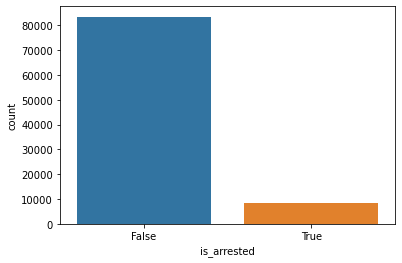

In [5]:
#Plotting categorical variables
#sns.countplot(x = df['stop_outcome'])
#sns.countplot(x = df['is_arrested'])
#sns.countplot(x = df['driver_race'])
sns.countplot(x = df['is_arrested'])
print(df.loc[df['is_arrested'] == True].value_counts)

In [6]:
#Dummifying categorical variables
df_dummies = pd.get_dummies(df, 
                            columns=['driver_gender', 'drugs_related_stop', 'is_arrested', 'violation','stop_duration', 'search_conducted', 'driver_race', 'timeOfDay', 'driver_age'])

df_dummies.drop(columns = ['stop_date','stop_time','is_arrested_False', 'driver_gender_F','drugs_related_stop_False', 'search_conducted_False', 'stop_outcome'], inplace = True)

df_dummies.dtypes

driver_gender_M                  uint8
drugs_related_stop_True          uint8
is_arrested_True                 uint8
violation_Equipment              uint8
violation_Moving violation       uint8
violation_Other                  uint8
violation_Registration/plates    uint8
violation_Seat belt              uint8
violation_Speeding               uint8
stop_duration_0-15 Min           uint8
stop_duration_1                  uint8
stop_duration_16-30 Min          uint8
stop_duration_2                  uint8
stop_duration_30+ Min            uint8
search_conducted_True            uint8
driver_race_Asian                uint8
driver_race_Black                uint8
driver_race_Hispanic             uint8
driver_race_Other                uint8
driver_race_White                uint8
timeOfDay_0                      uint8
driver_age_Unknown               uint8
driver_age_Baby                  uint8
driver_age_Child                 uint8
driver_age_Teenager              uint8
driver_age_Student       

In [7]:
#Generate completely unseen balanced dataset
df_arr = df_dummies[df_dummies.is_arrested_True==1].sample(200)
df_notarr = df_dummies[df_dummies.is_arrested_True==0].sample(200)
df_unseen = pd.concat([df_arr, df_notarr])
df_unseen.shape
df_unseen.to_csv('police_unseen.csv')


In [8]:
#Removing unseen dataset from original dataset
print(df_dummies.shape)
print(df_unseen.index)
df_dummies.drop(df_unseen.index, inplace = True)
df_dummies.reset_index()
df_dummies.shape

(91741, 29)
Int64Index([74706, 44648, 60212, 83495, 53486, 45525, 48682, 14991, 38785,
            73359,
            ...
            46530, 62984, 79659, 88269, 21206, 31982, 54149,  6694,  2874,
             2578],
           dtype='int64', length=400)


(91341, 29)

In [9]:
#Splitting into ind. (X) and dep. (Y) variables
X = df_dummies.drop(columns = ['is_arrested_True'], axis = 1)
Y = df_dummies['is_arrested_True'].to_numpy()

print(X)

       driver_gender_M  drugs_related_stop_True  violation_Equipment  \
0                    1                        0                    0   
1                    1                        0                    0   
2                    1                        0                    0   
3                    1                        0                    0   
4                    0                        0                    0   
...                ...                      ...                  ...   
91736                1                        0                    0   
91737                0                        0                    1   
91738                1                        0                    0   
91739                1                        0                    0   
91740                1                        0                    0   

       violation_Moving violation  violation_Other  \
0                               0                0   
1                          

In [10]:
from sklearn.model_selection import train_test_split
#Train Test split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=23) 

In [13]:
#Undersampling majority class
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(random_state = 40, sampling_strategy = 1)
x_bal, y_bal = under.fit_resample(x_train, y_train)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

#Modeling Random Forest

clf = RandomForestClassifier()
clf_balanced = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9],  
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Running the grid search on unbalanced data
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv = 10)
grid_obj = grid_obj.fit(x_train, y_train)

#Grid search for balanced data
grid_obj_balanced = GridSearchCV(clf_balanced, parameters, scoring=acc_scorer, cv = 10)
grid_obj_balanced = grid_obj_balanced.fit(x_bal, y_bal)

# Set each classifier to the best combination of parameters
clf = grid_obj.best_estimator_
clf_balanced = grid_obj_balanced.best_estimator_

# Fitting the best algorithms to the data
clf.fit(x_train, y_train)

#Training on balanced data
clf_balanced.fit(x_bal, y_bal)



RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=3,
                       n_estimators=6)

In [16]:
#Predictions
predictions = clf.predict(x_test)
predictions_bal = clf_balanced.predict(x_test)
print(accuracy_score(y_test, predictions))
print(accuracy_score(y_test, predictions_bal))

0.9677048552192238
0.9209590015873885


In [17]:
#Predict unseen

df_unseen = pd.read_csv('police_unseen.csv')
df_unseen.drop(columns = ['Unnamed: 0'], inplace = True)
df_unseen.shape

(400, 29)

In [18]:
#Using balanced / imbalanced models to predict unseen data
y_unseen = df_unseen.is_arrested_True

df_unseen.drop(columns = ['is_arrested_True'], inplace = True)

unseen_predictions = clf.predict(df_unseen)
unseen_predictions_bal = clf_balanced.predict(df_unseen)
print(accuracy_score(y_unseen, unseen_predictions))
print(accuracy_score(y_unseen, unseen_predictions_bal))


0.84
0.9175


In [21]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
confusion_matrix(unseen_predictions, y_unseen)
confusion_matrix(unseen_predictions_bal, y_unseen)

array([[190,  23],
       [ 10, 177]])

In [22]:
#Balanced Accuracies
print(balanced_accuracy_score(y_unseen, unseen_predictions))
print(balanced_accuracy_score(y_unseen, unseen_predictions_bal))

0.8400000000000001
0.9175
